In [5]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [6]:
isro_file = 'output.xlsx'
df_combined = pd.read_excel(isro_file)
df_combined['Date and Time'] = pd.to_datetime(df_combined['Date and Time'])
df_combined.set_index('Date and Time', inplace=True)


In [7]:
# Filter the dataset for one specific station (e.g., "APTFL")
Station = 'ABC_REN_RJ01'
features = [f'GHI_{Station}', f'Temperature_{Station}']
target = f'MW_{Station}'
df_combined = df_combined[features + [target]]
station_data = df_combined.copy()
station_data = station_data.reset_index()
#Ensure the datetime format is consistent
#station_data['Date and Time'] = pd.to_datetime(station_data['Date and Time'], format="%d-%m-%Y %H:%M", dayfirst=True)
station_data.columns = ['DateTime', 'GHI', 'Temperature', 'Generation']
# Extract the hour as a feature
station_data['Hour'] = station_data['DateTime'].dt.hour
station_data['GHI_Lag1']    = station_data['GHI'].shift(1)
station_data['GHI_Rolling'] = station_data['GHI'].rolling(window=3, min_periods=1).mean()
station_data = station_data[(station_data['Hour'] >= 6) & (station_data['Hour'] <= 19)]
len(station_data)


20384

In [8]:
def handle_missing_data(station_data):
    station_data.interpolate(method='linear', inplace=True)
    station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
    station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary
    return station_data
station_data = handle_missing_data(station_data)

/tmp/ipython-input-8-746033763.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
/tmp/ipython-input-8-746033763.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary


In [9]:
# Prepare features (GHI, Temperature, Hour) and target (Generation)
X_isro = station_data[['GHI', 'Temperature', 'Hour','GHI_Lag1','GHI_Rolling']].values
y_isro = station_data['Generation'].values
len(y_isro)

20384

In [10]:
scaler_X_isro = MinMaxScaler()
scaler_y_isro = MinMaxScaler()

X_scaled_isro = scaler_X_isro.fit_transform(X_isro)
y_scaled_isro = scaler_y_isro.fit_transform(y_isro.reshape(-1, 1))

# Get indices
train_idx, test_idx = train_test_split(np.arange(len(X_scaled_isro)), test_size=0.2, random_state=42)

# Use indices to split the data
X_train_isro, X_test_isro = X_scaled_isro[train_idx], X_scaled_isro[test_idx]
y_train_isro, y_test_isro = y_scaled_isro[train_idx], y_scaled_isro[test_idx]

# Reshape input data to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped_isro = X_train_isro.reshape((X_train_isro.shape[0], X_train_isro.shape[1], 1))
X_test_reshaped_isro = X_test_isro.reshape((X_test_isro.shape[0], X_test_isro.shape[1], 1))

In [11]:
# Define the LSTM model for ISRO data
model_isro = Sequential()

model_isro.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_reshaped_isro.shape[1], 1)))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=False))
model_isro.add(Dropout(0.3))

model_isro.add(Dense(units=1, activation='relu'))

# Compile the ISRO model
model_isro.compile(optimizer='adam', loss='mean_squared_error')

# Train the ISRO model with early stopping
early_stopping_isro = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_isro = model_isro.fit(X_train_reshaped_isro, y_train_isro, epochs=100, batch_size=32, validation_split=0.2,
                              callbacks=[early_stopping_isro], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0906 - val_loss: 0.0372
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0386 - val_loss: 0.0350
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0376 - val_loss: 0.0314
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0358 - val_loss: 0.0320
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0364 - val_loss: 0.0308
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0335 - val_loss: 0.0306
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0332 - val_loss: 0.0313
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0326 - val_loss: 0.0315
Epoch 9/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0332 - val_loss: 0.0307
Epoch 10/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0335 - val_loss: 0.0310
Epoch 11/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0319 - val_loss: 0.0303
Epoch 12/100
408/408 ━━

In [12]:
# Make predictions on the test set
y_pred_scaled_isro = model_isro.predict(X_test_reshaped_isro)

# Inverse transform the predictions and the actual values
y_pred_isro = scaler_y_isro.inverse_transform(y_pred_scaled_isro)
y_test_actual_isro = scaler_y_isro.inverse_transform(y_test_isro)
station_data.sort_values(by='DateTime',ascending = True)
# Extract corresponding datetime from the test set using test_idx
test_dates = station_data['DateTime'].iloc[test_idx]

# Calculate Evaluation Metrics (MAE and R²)
mae_isro = mean_absolute_error(y_test_actual_isro, y_pred_isro)
r2_isro = r2_score(y_test_actual_isro, y_pred_isro)

print(f"Mean Absolute Error (MAE): {mae_isro:.4f}")
print(f"R² Score: {r2_isro:.4f}")

# Print the first 10 actual vs predicted values with timestamps
print("Time: Actual vs Predicted values:")
for i in range(30):
    print(f"Time: {test_dates.iloc[i]}, Actual: {y_test_actual_isro[i][0]:.3f}, Predicted: {y_pred_isro[i][0]:.6f}")


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Mean Absolute Error (MAE): 29.4554
R² Score: 0.8142
Time: Actual vs Predicted values:
Time: 2025-03-08 17:30:00, Actual: 155.264, Predicted: 68.572281
Time: 2024-06-24 11:00:00, Actual: 263.680, Predicted: 276.972656
Time: 2024-08-18 07:45:00, Actual: 82.176, Predicted: 67.629402
Time: 2024-11-13 12:00:00, Actual: 302.336, Predicted: 248.177597
Time: 2024-11-13 12:15:00, Actual: 302.592, Predicted: 242.204727
Time: 2024-06-12 08:45:00, Actual: 182.656, Predicted: 172.777191
Time: 2025-03-11 15:15:00, Actual: 132.096, Predicted: 214.690231
Time: 2024-10-25 18:45:00, Actual: 3.669, Predicted: 12.095469
Time: 2024-04-22 07:30:00, Actual: 71.680, Predicted: 50.474113
Time: 2025-01-04 14:30:00, Actual: 252.416, Predicted: 212.006454
Time: 2024-05-27 07:45:00, Actual: 102.656, Predicted: 87.760918
Time: 2024-10-13 12:15:00, Actual: 161.408, Predicted: 280.203583
Time: 2024-06-27 08:00:00, Actual: 110.080, Predicted: 65.674713
Time: 2024-06-16 06:30:00

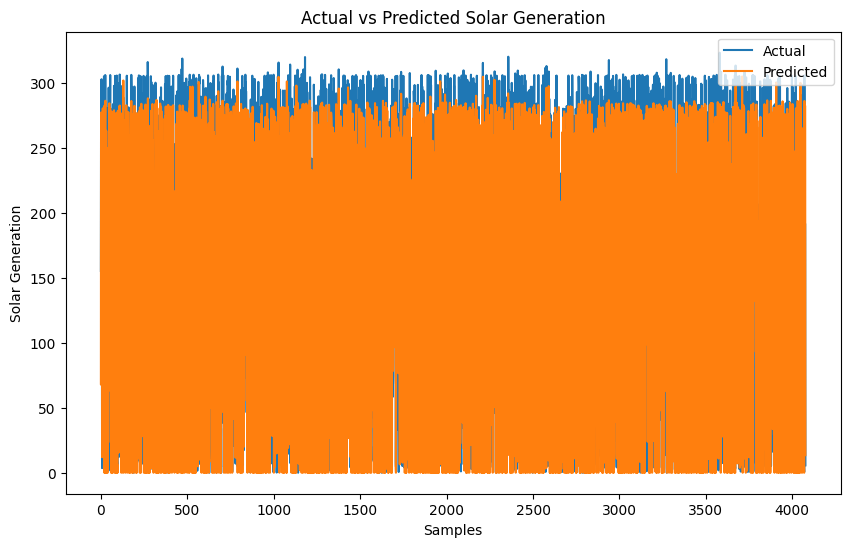

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_isro, label='Actual')
plt.plot(y_pred_isro, label='Predicted')
plt.title('Actual vs Predicted Solar Generation')
plt.xlabel('Samples')
plt.ylabel('Solar Generation')
plt.legend()
plt.show()

In [18]:
# Future Prediction (Converting GMT to IST and Predicting Solar Generation)
future_data_file = 'POSOCO_SolarForecast_SWFlux_20250715_ABC_REN_RJ01.csv'
future_df = pd.read_csv(future_data_file)

# Rename columns for simplicity
future_df.columns = ['DateTime', 'Temperature', 'GHI']

# Convert the 'DateTime' column to datetime and convert GMT to IST (GMT + 5:30)
future_df['DateTime'] = pd.to_datetime(future_df['DateTime'])
future_df['DateTime'] = future_df['DateTime'] + pd.Timedelta(hours=5, minutes=30)

# Extract the hour from the DateTime column
future_df['Hour'] = future_df['DateTime'].dt.hour
future_df['GHI_Lag1'] = future_df['GHI'].shift(1)
future_df['GHI_Rolling'] = future_df['GHI'].rolling(window=3, min_periods=1).mean()
future_df = future_df[(future_df['Hour'] >= 6) & (future_df['Hour'] <= 19)]
# Extract the same features: GHI, Temperature, and Hour
X_future = future_df[['GHI', 'Temperature', 'Hour','GHI_Lag1','GHI_Rolling']].values

# Normalize the future features using the same scaler used for training
X_future_scaled = scaler_X_isro.transform(X_future)

# Reshape the input for the LSTM model (3D)
X_future_reshaped = X_future_scaled.reshape((X_future_scaled.shape[0], X_future_scaled.shape[1], 1))

# Make predictions on the future data
y_future_scaled = model_isro.predict(X_future_reshaped)

# Inverse transform the predictions to get the original scale
y_future_pred = scaler_y_isro.inverse_transform(y_future_scaled)

# Combine the predictions with the corresponding timestamps
future_predictions = pd.DataFrame({'DateTime': future_df['DateTime'], 'Predicted Generation': y_future_pred.flatten()})

# Save the future predictions to a file
future_predictions.to_csv('future_solar_generation_predictions.csv', index=False)

# Save the trained model for future use
model_isro.save('solar_generation_model.h5')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
